In [1]:
import pylab
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import algorithms as algo

In [2]:
import pandas as pd
dataset='datasets/export'
files = ["L185_0_A9_1", "L185_0_A10_1", "L186_0_A11_1","L186_0_A12_1",
         "L187_0_B1_1", "L187_0_B2_1",  "L291_0_A1_1", "L291_0_A2_1",
        ]
i = 2
print(f"{dataset}/{files[i]}.txt")
df= pd.read_table(f"{dataset}/{files[i]}.txt",
                  sep=" ", 
                  header=None,
                  names=['m/z', 'intensity']) 
df.head()

datasets/export/L186_0_A11_1.txt


,m/z,intensity
0,997.552,6966
1,997.646,6942
2,997.741,7003
3,997.836,7068
4,997.931,7122


In [3]:
x = df['m/z'].to_numpy()
y = df['intensity'].to_numpy()
print(x[:5])
print(y[:5])

[997.552 997.646 997.741 997.836 997.931]
[6966 6942 7003 7068 7122]


# SciPy: scipy.signal.find_peaks
- `height` : Required height of peaks.
- `distance`: Required threshold of peaks, the vertical distance to its neighboring samples.
- `prominence`: Required minimal horizontal distance (>= 1) in samples between neighbouring peaks
- `threshold` : Required prominence of peaks.
- `width`: Required width of peaks in samples
- `wlen` : Used for calculation of the peaks prominences, if one of `prominence` or `width` is given.
- `rel_height`: Used for calculation of the peaks width, if `width` is given.
- `plateau_size`: Required size of the flat top of peaks in samples.

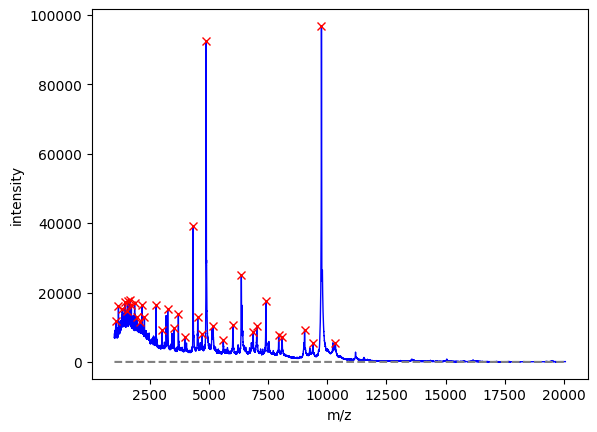

In [4]:
# 基本的Peak検出

dist, prom = 500, 3000
peaks,_ = signal.find_peaks(y, distance=dist, prominence=prom)
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, y, lw=1, color="blue")
plt.plot(x[peaks], y[peaks], "rx")
plt.plot(x,np.zeros_like(y), "--", color="gray")
plt.show()

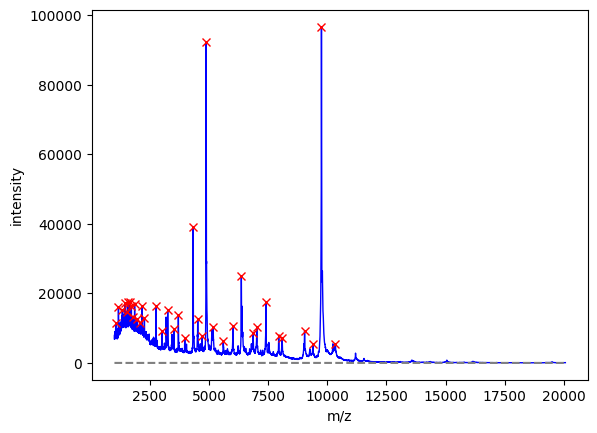

In [5]:
# 平滑化を適用

window = 15
deg = 2   
smoothed = signal.savgol_filter(y, window, deg, deriv=0)
peaks,_ = signal.find_peaks(smoothed, distance=dist, prominence=prom)

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, smoothed, lw=1, color="blue")
plt.plot(x[peaks], smoothed[peaks], "rx")
plt.plot(x, np.zeros_like(y), "--", color="gray")
plt.show()

# Baseline Correction

## pybaselines · PyPI
cf. https://github.com/derb12/pybaselines <br> 
A Python library of algorithms for the baseline correction of experimental data. `pybaselines` has 50+ baseline correction algorithms. 
- Polynomial methods (`pybaselines.polynomial`), 
- Whittaker-smoothing-based methods (`pybaselines.whittaker`), 
- Morphological methods (`pybaselines.morphological`), 
- Spline methods (`pybaselines.spline`) 
- Smoothing-based methods (`pybaselines.smooth`)
- Baseline/Peak Classification methods (`pybaselines.classification`)
- Optimizers (`pybaselines.optimizers`)
- Miscellaneous methods (`pybaselines.misc`)

In [6]:
from pybaselines import Baseline, utils
# Erb, D. (2022). pybaselines: A Python library of algorithms for the baseline correction of experimental data. 
# https://doi.org/10.5281/zenodo.5608581.

In [7]:
# 様々なBaseline補正

baseline_fitter = Baseline(x_data=x)
bkg_1 = baseline_fitter.modpoly(y, poly_order=3)[0]
bkg_2 = baseline_fitter.asls(y, lam=1e7, p=0.02)[0]
bkg_3 = baseline_fitter.mor(y, half_window=30)[0]
bkg_4 = baseline_fitter.snip(
    y, max_half_window=40, decreasing=True, smooth_half_window=3
)[0]

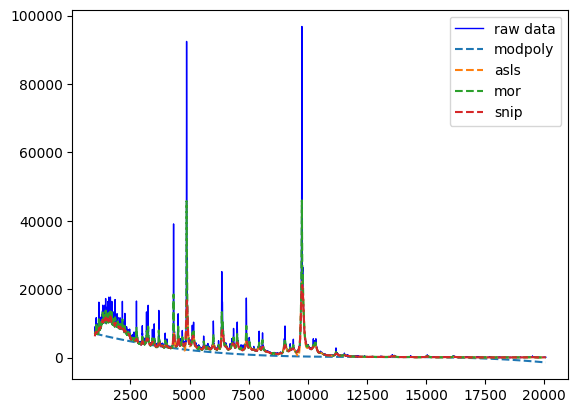

In [8]:
plt.plot(x, y, label='raw data', lw=1, color="blue")
plt.plot(x, bkg_1, '--', label='modpoly')
plt.plot(x, bkg_2, '--', label='asls')
plt.plot(x, bkg_3, '--', label='mor')
plt.plot(x, bkg_4, '--', label='snip')
plt.legend()
plt.show()

total peaks=33


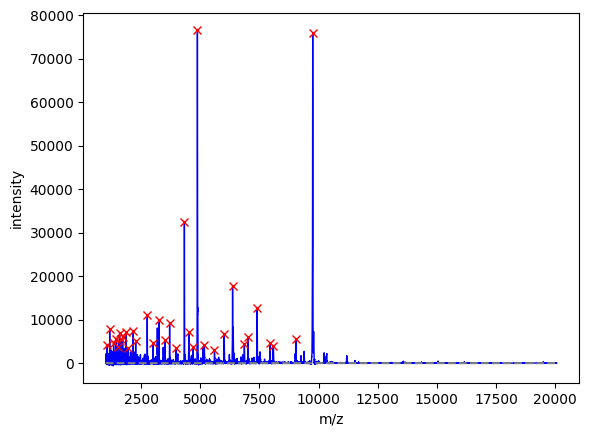

In [9]:
# Baseline補正を適用したPeak検出

dist, prom = 500, 3000
z =  y - bkg_4
peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)
print(f"total peaks={len(peaks)}")
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.plot(x, z, lw=1, color="blue")
plt.plot(x[peaks], z[peaks], "rx")
plt.plot(x,np.zeros_like(z), "--", color="gray")
plt.show()

In [10]:
for s in range(0,12000,3000):
    n = len([p for p in peaks if s < x[p] < s+3000])
    print(f"[{s},{s+3000}]\t peaks = {n}")

[0,3000]	 peaks = 13
[3000,6000]	 peaks = 11
[6000,9000]	 peaks = 7
[9000,12000]	 peaks = 2


In [11]:
# すべてのデータセットに対して、Peak検出を行う。
# pybaselinesによるBaseline補正
# 結果をpeaks_indという辞書に保存する

peaks_in = dict()
for file in files:
#     print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    window = 15
    deg = 2   
    smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    base_filter = Baseline(x_data=x)
    bkg = base_filter.asls(y, lam=1e7, p=0.02)[0]
#     bkg = baseline_fitter.mor(y, half_window=30)[0]
    z = smoothed - bkg
    peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)
    
    peaks_in[file] = (x[peaks], z[peaks]) 
#     plt.xlabel("m/z")
#     plt.ylabel("intensity")
#     plt.plot(x, z)
#     plt.plot(x[peaks], z[peaks], "rx")
#     plt.plot(x, np.zeros_like(y), "--", color="gray")
#     plt.show()

In [12]:
for k in peaks_in:
    print(f'{k}のPeak数:\t{len(peaks_in[k][0])}')

L185_0_A9_1のPeak数:	40
L185_0_A10_1のPeak数:	39
L186_0_A11_1のPeak数:	34
L186_0_A12_1のPeak数:	30
L187_0_B1_1のPeak数:	20
L187_0_B2_1のPeak数:	23
L291_0_A1_1のPeak数:	11
L291_0_A2_1のPeak数:	26


In [13]:
# m/zの値は精確ではないため、下記の関数で結果を丸める
def fmt(f, d=1):
    """ 実数を整数に丸める。d:桁数 d桁以内四捨五入 
       例：fmt(3456.78,d=1) == 3460, fmt(3456.78,d=2) == 3500
    """
    return round(int(f), -d)

def pik(pk,d=1):
    """ Peaksのm/z値を丸め、辞書にして返す
    """
    npk =  ([fmt(x,d=d) for x in pk[0]],pk[1]) # m/zを丸める
    return dict(zip(npk[0], npk[1]))

In [14]:
# 共通Peak数を調べる

data = []
n = len(files)
for i in range(n-1):
    p1,p2 = files[i], files[i+1]
    pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
    c = len(pk1.keys() & pk2.keys())
    print(f'{p1}と{p2}の共通Peak数:\t{c}')

L185_0_A9_1とL185_0_A10_1の共通Peak数:	30
L185_0_A10_1とL186_0_A11_1の共通Peak数:	30
L186_0_A11_1とL186_0_A12_1の共通Peak数:	27
L186_0_A12_1とL187_0_B1_1の共通Peak数:	17
L187_0_B1_1とL187_0_B2_1の共通Peak数:	18
L187_0_B2_1とL291_0_A1_1の共通Peak数:	11
L291_0_A1_1とL291_0_A2_1の共通Peak数:	10


In [15]:
# 類似度計算
import math

def jacard(pk1, pk2, weighted=False):
    """ Jacard Similarity
    """
    c =  pk1.keys() & pk2.keys()
    d1 = pk1.keys() - pk2.keys()
    d2 = pk2.keys() - pk1.keys()
    n = len(c) + len(d1) + len(d2)
    return len(c)/ float(n)

In [16]:
# Compute Jacard Similarity 

n = len(files)

print('Jacard Similarity:')
rs = []
for i in range(n-1):
    for j in range(i+1,n):
        if i == j:
            continue
        p1,p2 = files[i], files[j]
        pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
        # print(f'{p1},\t{p2}:{jacard(pk1, pk2)}')
        similarity = jacard(pk1, pk2)
        rs += [(i, j, similarity)]

for i, j, score in sorted(rs, key=lambda x: x[2], reverse=True):
    tag = "*" if files[i][:4]==files[j][:4] else ""
    print(f'{files[i]} &\t {files[j]}: \t {score:.4f} {tag}')

Jacard Similarity:
L186_0_A11_1 &	 L186_0_A12_1: 	 0.7297 *
L187_0_B1_1 &	 L187_0_B2_1: 	 0.7200 *
L185_0_A10_1 &	 L186_0_A11_1: 	 0.6977 
L185_0_A10_1 &	 L186_0_A12_1: 	 0.6429 
L185_0_A9_1 &	 L186_0_A12_1: 	 0.6279 
L185_0_A9_1 &	 L185_0_A10_1: 	 0.6122 *
L186_0_A12_1 &	 L187_0_B2_1: 	 0.6061 
L186_0_A12_1 &	 L291_0_A2_1: 	 0.6000 
L187_0_B1_1 &	 L291_0_A2_1: 	 0.5862 
L185_0_A10_1 &	 L291_0_A2_1: 	 0.5854 
L186_0_A11_1 &	 L291_0_A2_1: 	 0.5789 
L187_0_B1_1 &	 L291_0_A1_1: 	 0.5500 
L185_0_A9_1 &	 L186_0_A11_1: 	 0.5417 
L187_0_B2_1 &	 L291_0_A2_1: 	 0.5312 
L186_0_A12_1 &	 L187_0_B1_1: 	 0.5152 
L187_0_B2_1 &	 L291_0_A1_1: 	 0.4783 
L186_0_A11_1 &	 L187_0_B2_1: 	 0.4615 
L185_0_A9_1 &	 L291_0_A2_1: 	 0.4348 
L185_0_A9_1 &	 L187_0_B2_1: 	 0.4318 
L185_0_A9_1 &	 L187_0_B1_1: 	 0.4286 
L186_0_A11_1 &	 L187_0_B1_1: 	 0.3846 
L185_0_A10_1 &	 L187_0_B2_1: 	 0.3778 
L185_0_A10_1 &	 L187_0_B1_1: 	 0.3721 
L291_0_A1_1 &	 L291_0_A2_1: 	 0.3704 *
L186_0_A12_1 &	 L291_0_A1_1: 	 0.3667 
L185_0_A

In [17]:
from BaselineRemoval import BaselineRemoval

In [18]:
# すべてのデータセットに対して、Peak検出を行う。
#  BaselineRemovalによるBaseline補正
# 結果をpeaks_indという辞書に保存する

peaks_in = {}
for file in files:
#     print(f"{dataset}/{file}.txt")
    df = None
    df= pd.read_table(f"{dataset}/{file}.txt",
                      sep=" ", 
                      header=None,
                      names=['m/z', 'intensity']) 
    x = df['m/z'].to_numpy()
    y = df['intensity'].to_numpy()
    smoothed = y
#     window = 15
#     deg = 2   
#     smoothed = signal.savgol_filter(y, window, deg, deriv=0)
    brm = BaselineRemoval(smoothed)    
    z = brm.ZhangFit(lambda_=100,repitition=15, porder=1)
    peaks,_ = signal.find_peaks(z, distance=dist, prominence=prom)

    peaks_in[file] = (x[peaks], z[peaks]) 
#     plt.xlabel("m/z")
#     plt.ylabel("intensity")
#     plt.plot(x, z)
#     plt.plot(x[peaks], z[peaks], "rx")
#     plt.plot(x, np.zeros_like(y), "--", color="gray")
#     plt.show()

for k in peaks_in:
    print(f'{k}のPeak数:\t{len(peaks_in[k][0])}')

L185_0_A9_1のPeak数:	38
L185_0_A10_1のPeak数:	38
L186_0_A11_1のPeak数:	33
L186_0_A12_1のPeak数:	29
L187_0_B1_1のPeak数:	20
L187_0_B2_1のPeak数:	23
L291_0_A1_1のPeak数:	11
L291_0_A2_1のPeak数:	28


In [19]:
# 共通Peak数を調べる

data = []
n = len(files)
for i in range(n-1):
    p1,p2 = files[i], files[i+1]
    pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
    c = len(pk1.keys() & pk2.keys())
    print(f'{p1}と{p2}の共通Peak数:\t{c}')


L185_0_A9_1とL185_0_A10_1の共通Peak数:	31
L185_0_A10_1とL186_0_A11_1の共通Peak数:	32
L186_0_A11_1とL186_0_A12_1の共通Peak数:	27
L186_0_A12_1とL187_0_B1_1の共通Peak数:	14
L187_0_B1_1とL187_0_B2_1の共通Peak数:	18
L187_0_B2_1とL291_0_A1_1の共通Peak数:	11
L291_0_A1_1とL291_0_A2_1の共通Peak数:	10


In [20]:
# Compute Jacard Similarity 

n = len(files)

print('Jacard Similarity:')
rs = []
for i in range(n-1):
    for j in range(i+1,n):
        if i == j:
            continue
        p1,p2 = files[i], files[j]
        pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
        # print(f'{p1},\t{p2}:{jacard(pk1, pk2)}')
        similarity = jacard(pk1, pk2)
        rs += [(i, j, similarity)]


for i, j, score in sorted(rs, key=lambda x: x[2], reverse=True):
    tag = "*" if files[i][:4]==files[j][:4] else ""
    print(f'{files[i]} &\t {files[j]}: \t {score:.4f} {tag}')

Jacard Similarity:
L185_0_A10_1 &	 L186_0_A11_1: 	 0.8205 
L186_0_A11_1 &	 L186_0_A12_1: 	 0.7714 *
L187_0_B1_1 &	 L187_0_B2_1: 	 0.7200 *
L185_0_A9_1 &	 L185_0_A10_1: 	 0.6889 *
L185_0_A10_1 &	 L186_0_A12_1: 	 0.6750 
L185_0_A9_1 &	 L186_0_A11_1: 	 0.6512 
L185_0_A9_1 &	 L186_0_A12_1: 	 0.6341 
L186_0_A12_1 &	 L291_0_A2_1: 	 0.6286 
L186_0_A11_1 &	 L291_0_A2_1: 	 0.6053 
L187_0_B1_1 &	 L291_0_A1_1: 	 0.5500 
L187_0_B2_1 &	 L291_0_A2_1: 	 0.5455 
L185_0_A9_1 &	 L291_0_A2_1: 	 0.5349 
L185_0_A10_1 &	 L291_0_A2_1: 	 0.5349 
L187_0_B1_1 &	 L291_0_A2_1: 	 0.5000 
L185_0_A9_1 &	 L187_0_B2_1: 	 0.4878 
L186_0_A12_1 &	 L187_0_B2_1: 	 0.4857 
L187_0_B2_1 &	 L291_0_A1_1: 	 0.4783 
L186_0_A11_1 &	 L187_0_B2_1: 	 0.4359 
L186_0_A11_1 &	 L187_0_B1_1: 	 0.4324 
L185_0_A9_1 &	 L187_0_B1_1: 	 0.4146 
L186_0_A12_1 &	 L187_0_B1_1: 	 0.4000 
L185_0_A10_1 &	 L187_0_B1_1: 	 0.3810 
L185_0_A10_1 &	 L187_0_B2_1: 	 0.3556 
L291_0_A1_1 &	 L291_0_A2_1: 	 0.3448 *
L186_0_A11_1 &	 L291_0_A1_1: 	 0.2941 
L186_0_A

In [21]:
import math

def rank(pk):
    """ Ranking peaks by intensity
      returns a new dict with rank for each m/z value 
    """
    return {key: rank for rank, key in enumerate(sorted(pk, key=pk.get, reverse=True), 1)}

def sigmoid(x, y):
    e = math.e
    w = 1.50 - 1 / float(1+e**-abs(x-y))
    p = 4/float(x+y) 
    return w + p

def weighted_jacard(pk1, pk2):
    """ 
    """
    m, n = len(pk1), len(pk2)
    r1, r2 = rank(pk1), rank(pk2)
    c =  r1.keys() & r2.keys()
    scores =  [sigmoid(r1[mz], r2[mz]) for mz in c]
    return sum(scores)
            
for i in range(1,6):
    for j in range(i,6):
        print(i,j,sigmoid(i,j))

1 1 3.0
1 2 2.1022747547033283
1 3 1.6192029220221178
1 4 1.347425873177567
1 5 1.1846528766287583
2 2 2.0
2 3 1.568941421369995
2 4 1.2858695886887843
2 5 1.1188544446061384
3 3 1.6666666666666665
3 4 1.3403699927985664
3 5 1.1192029220221178
4 4 1.5
4 5 1.2133858658144394
5 5 1.4


In [22]:
# Jacard Similarity 

n = len(files)
print('Weighted Jacard Similarity:')
rs = []
for i in range(n-1):
    for j in range(i+1,n):
        if i==j:
            continue
        p1,p2 = files[i], files[j]
        pk1, pk2 = pik(peaks_in[p1]), pik(peaks_in[p2])
        # print(f'{p1},\t{p2}:{jacard(pk1, pk2)}')
        similarity = weighted_jacard(pk1, pk2)
        rs += [(i, j, similarity)]

for i, j, score in sorted(rs, key=lambda x: x[2], reverse=True):
    tag = "*" if files[i][:4]==files[j][:4] else ""
    print(f'{files[i]} &\t {files[j]}: \t {score:.4f} {tag}')

Weighted Jacard Similarity:
L185_0_A10_1 &	 L186_0_A11_1: 	 29.5289 
L185_0_A9_1 &	 L185_0_A10_1: 	 26.1648 *
L186_0_A11_1 &	 L186_0_A12_1: 	 25.0770 *
L185_0_A10_1 &	 L186_0_A12_1: 	 25.0611 
L185_0_A9_1 &	 L186_0_A11_1: 	 24.7001 
L185_0_A9_1 &	 L186_0_A12_1: 	 23.3179 
L186_0_A11_1 &	 L291_0_A2_1: 	 22.1611 
L185_0_A10_1 &	 L291_0_A2_1: 	 20.6592 
L185_0_A9_1 &	 L291_0_A2_1: 	 20.2882 
L187_0_B1_1 &	 L187_0_B2_1: 	 20.2163 *
L185_0_A9_1 &	 L187_0_B2_1: 	 20.0753 
L186_0_A12_1 &	 L291_0_A2_1: 	 19.7207 
L187_0_B2_1 &	 L291_0_A2_1: 	 18.3186 
L187_0_B1_1 &	 L291_0_A2_1: 	 17.5039 
L186_0_A11_1 &	 L187_0_B1_1: 	 16.3566 
L185_0_A9_1 &	 L187_0_B1_1: 	 16.3502 
L186_0_A11_1 &	 L187_0_B2_1: 	 16.2418 
L185_0_A10_1 &	 L187_0_B2_1: 	 15.6224 
L187_0_B2_1 &	 L291_0_A1_1: 	 15.4136 
L185_0_A10_1 &	 L187_0_B1_1: 	 15.1929 
L186_0_A12_1 &	 L187_0_B2_1: 	 15.1171 
L187_0_B1_1 &	 L291_0_A1_1: 	 14.3408 
L185_0_A9_1 &	 L291_0_A1_1: 	 13.8439 
L186_0_A11_1 &	 L291_0_A1_1: 	 12.7372 
L291_0_A1_1 &	 